In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)

for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.1.0
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.17.2
pandas 0.25.1
sklearn 0.21.3
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [5]:
train_file = "data/titanic/train.csv"
eval_file = "data/titanic/eval.csv"

In [6]:
train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

In [7]:
train_df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [10]:
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

print(y_train.head())

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64


In [11]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [14]:
train_df.shape

(627, 9)

In [15]:
eval_df.shape

(264, 9)

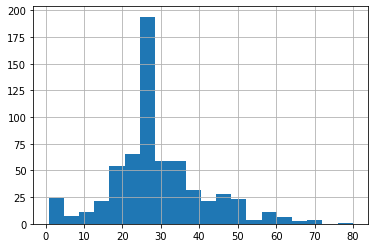

In [16]:
train_df.age.hist(bins=20)

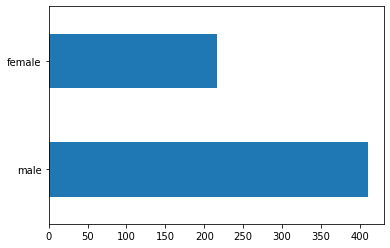

In [19]:
train_df.sex.value_counts().plot(kind="barh")

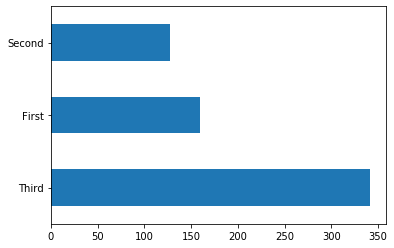

In [20]:
train_df['class'].value_counts().plot(kind='barh')

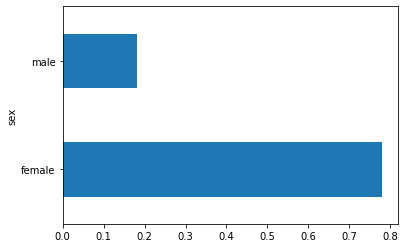

In [24]:
pd.concat([train_df,y_train],axis=1).groupby('sex').survived.mean().plot(kind='barh')

In [26]:
train_df.columns

Index(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck',
       'embark_town', 'alone'],
      dtype='object')

In [30]:
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
       'embark_town', 'alone']

numeric_columns = ['age', 'fare']

feature_columns = []

# 離散特徵轉換
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    feature_columns.append(
        tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(
    categorical_column, vocab)))
    

# 連續特徵轉換
for numeric_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            numeric_column,dtype=tf.float32))

In [29]:
print(feature_columns)

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='embark_town', voca

In [34]:
def make_dataset(data_df,label_df,epochs=10, shuffle=True,
                 batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(data_df),label_df))
        
    if shuffle:
        dataset = dataset.shuffle(10000)
    
    dataset = dataset.repeat(epochs).batch(batch_size)
    
    return dataset

In [35]:
train_dataset = make_dataset(train_df,y_train, batch_size=5)

In [36]:
for x,y in train_dataset.take(1):
    print(x,y)

{'sex': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'male', b'male', b'male', b'male', b'male'], dtype=object)>, 'age': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([28., 62., 17., 28.,  1.])>, 'n_siblings_spouses': <tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 0, 0, 4], dtype=int32)>, 'parch': <tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 2, 0, 1], dtype=int32)>, 'fare': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([  7.75  ,  10.5   , 110.8833,   7.775 ,  39.6875])>, 'class': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Third', b'Second', b'First', b'Third', b'Third'], dtype=object)>, 'deck': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'unknown', b'unknown', b'C', b'unknown', b'unknown'], dtype=object)>, 'embark_town': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'Queenstown', b'Southampton', b'Cherbourg', b'Southampton',
       b'Southampton'], dtype=object)>, 'alone': <tf.Tensor: shape=(5,), dtype=string, numpy=array([

In [44]:
# keras.layers.DenseFeature

for x,y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy)
    print(keras.layers.DenseFeatures(gender_column)(x).numpy)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[28.],
       [71.],
       [ 2.],
       [61.],
       [45.]], dtype=float32)>>

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype